In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from gpdc2d import *
from scipy.linalg.blas import sgemm
import numexpr as ne
from scipy import signal
from copy import copy
import matplotlib.colors as colors 
from skimage import color, data, restoration
import matplotlib.ticker as ticker



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def make_plot(image_name, filter_type, obs_ratio, show_titles=False, hide_x=True):
    dim = 32

    # save results
    x = np.load("computations/original_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    f = np.load("computations/convoved_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    y =np.load("computations/input_image_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    obs_idx = np.load("computations/observation_indices_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    h = np.load("computations/filter_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    gpdc = np.load("computations/GPDC_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))
    blind_gpdc = np.load("computations/blind-GPDC_{}_{}_{}.npy".format(image_name, filter_type, obs_ratio))

    palette = copy(plt.cm.gray)
    palette.set_under('r', 1.)
    y_img = -1e3 *np.ones((dim,dim)).reshape(-1)
    y_img[obs_idx] = y
    y_img = y_img.reshape(dim,dim)

    # show data
    fig, axes = plt.subplots(1,8, figsize=(30,20))
    axes[0].imshow(h, cmap='gray', vmin = np.min(h)-1e-3, vmax=np.max(h)+1e-3)
    axes[1].imshow(x, cmap='gray')
    axes[2].imshow(f, cmap='gray')
    axes[3].imshow(y_img, cmap=palette,
              norm=colors.Normalize(vmin=np.min(y), vmax=np.max(y)))
    axes[4].imshow(gpdc.reshape(dim, dim), cmap='gray')
    axes[5].imshow(blind_gpdc.reshape(dim, dim), cmap='gray')

    losses = np.load('computations/mse_{}_{}.npy'.format(image_name, filter_type))
    mean = losses.mean(axis=0)
    error = losses.std(axis=0)
    step = 0.05
    ratios = np.arange(0.1,1+step, step)


    if image_name == 'chequered':
        b = 0.06
    elif image_name == 'horse':
        b = 0.008
    elif image_name == 'woven':
        b = 0.01
    elif image_name == 'emu':
        b = 0.08
    elif image_name == 'grid':
        b = 0.002
    elif image_name == 'plane':
        b = 0.03
    elif image_name == 'bird':
        b = 0.01
    elif image_name == 'rider':
        b = 0.02
    elif image_name == 'swiss_plane':
        b = 0.01
    elif image_name == 'frog':
        b = 0.01
    elif image_name == 'horse':
        b = 0.01
    errs=[]
    balances = np.arange(0,1., .01)
    for b in balances:
        d = restoration.wiener(f, h, balance=b, clip=False )
        wiener_error = np.mean(np.abs(d.reshape(-1) - x.reshape(-1))**2)
        errs.append(wiener_error)

    idx = np.argmin(errs)
    wiener_image = restoration.wiener(f, h, balance=balances[idx], clip=False )
    wiener_error = np.mean(np.abs(wiener_image.reshape(-1) - x.reshape(-1))**2)

    axes[6].imshow(wiener_image, cmap='gray')

    axes[7].plot(ratios, mean, color='b')
    axes[7].plot(ratios, wiener_error * np.ones(len(ratios)), color='r', label='Wiener')
    axes[7].fill_between(ratios, mean - error, mean + error, color='b', alpha=0.3, label='GPDC')
    axes[7].yaxis.grid()
    axes[7].set_yticks(np.arange(0, np.max(mean+error), 0.1))
    axes[7].set_yticklabels(np.arange(0, np.max(mean+error), 0.1), fontsize=30)
    axes[7].set_xticks([0.25, 0.5, 0.75])
    axes[7].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    axes[7].set_xticklabels([0.25, 0.5, 0.75], fontsize=30)
    axes[7].set_ylabel('MSE', fontsize=30)
    axes[7].set_xlabel('observation ratio', fontsize=30)

    axes[7].yaxis.tick_right()
    axes[7].yaxis.set_label_position("right")


    asp = np.diff(axes[7].get_xlim())[0] / np.diff(axes[7].get_ylim())[0]
    axes[7].set_aspect(asp)

    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    axes[1].get_xaxis().set_visible(False)
    axes[1].get_yaxis().set_visible(False)
    axes[2].get_xaxis().set_visible(False)
    axes[2].get_yaxis().set_visible(False)
    axes[3].get_xaxis().set_visible(False)
    axes[3].get_yaxis().set_visible(False)
    axes[4].get_xaxis().set_visible(False)
    axes[4].get_yaxis().set_visible(False)
    axes[5].get_xaxis().set_visible(False)
    axes[5].get_yaxis().set_visible(False)
    axes[6].get_xaxis().set_visible(False)
    axes[6].get_yaxis().set_visible(False)

    if hide_x:
        axes[7].get_xaxis().set_visible(False)


    if show_titles:
        #axes[7].legend(bbox_to_anchor=(.7,.6), fontsize=25)
        axes[7].legend(loc='upper left',fontsize=25)

        axes[0].set_title("filter", fontsize=30)
        axes[1].set_title("x", fontsize=30)
        axes[2].set_title("f", fontsize=30)
        axes[3].set_title("y", fontsize=30)
        axes[4].set_title("GPDC", fontsize=30)
        axes[5].set_title("blind-GPDC", fontsize=30)
        axes[6].set_title("Wiener", fontsize=30)
        axes[7].set_title("Performance", fontsize=30)


    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.02, hspace=.00)
    fig.savefig("figures/{}_{}_{}.pdf".format(image_name, filter_type, obs_ratio), bbox_inches='tight')

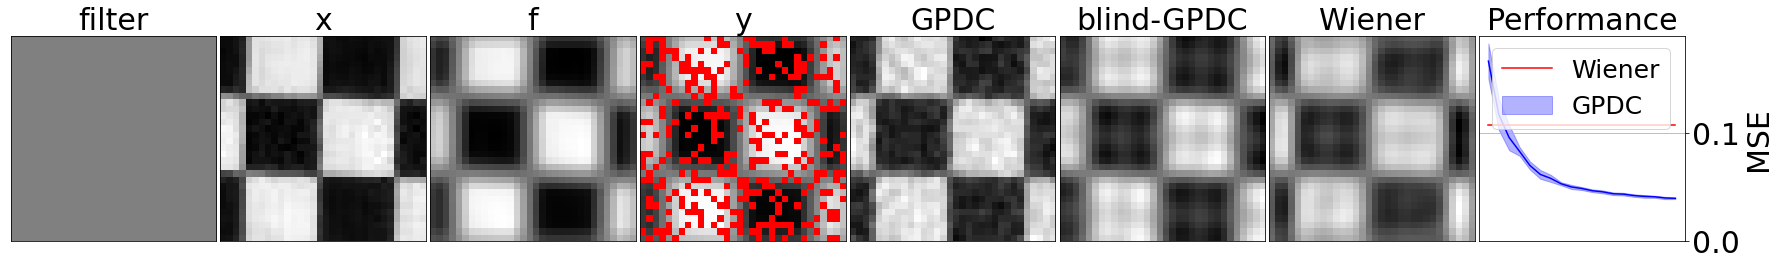

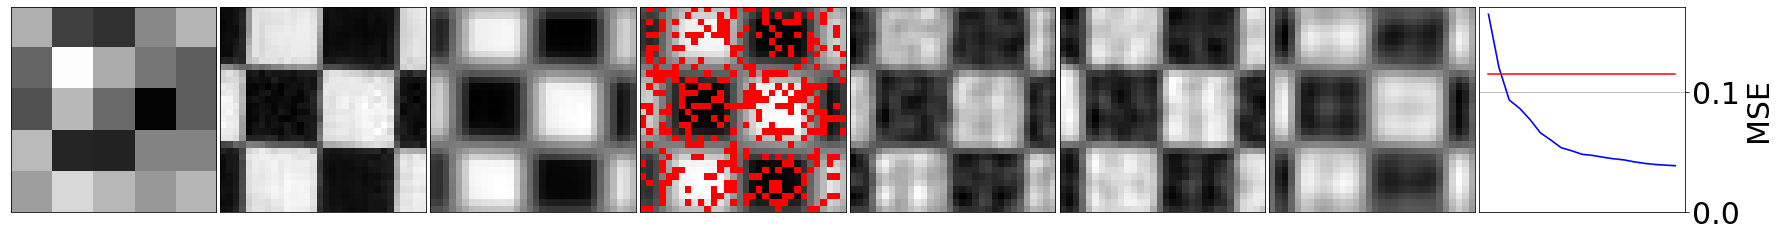

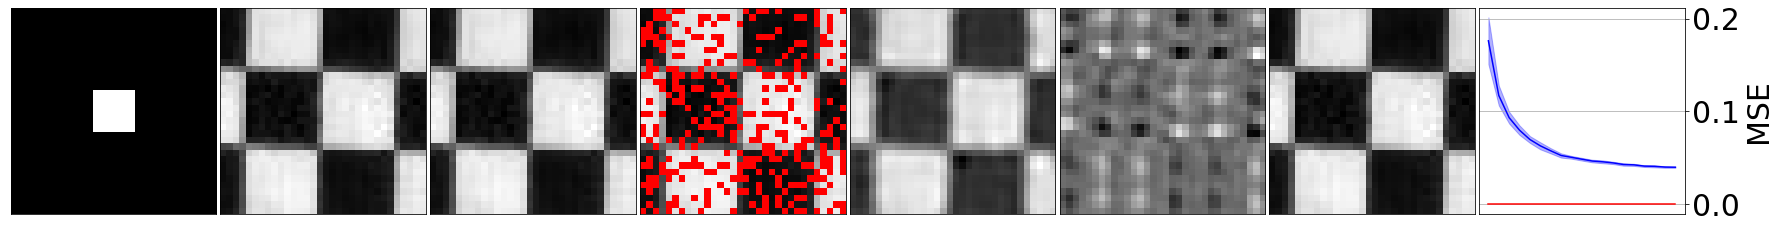

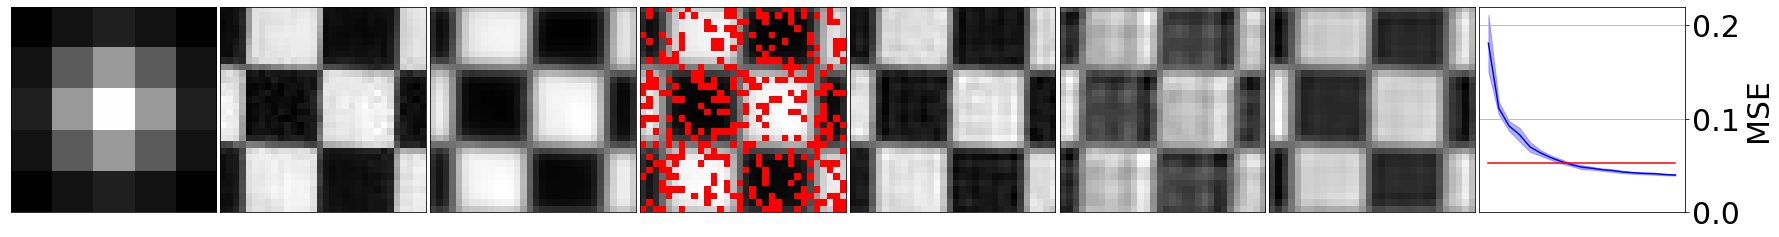

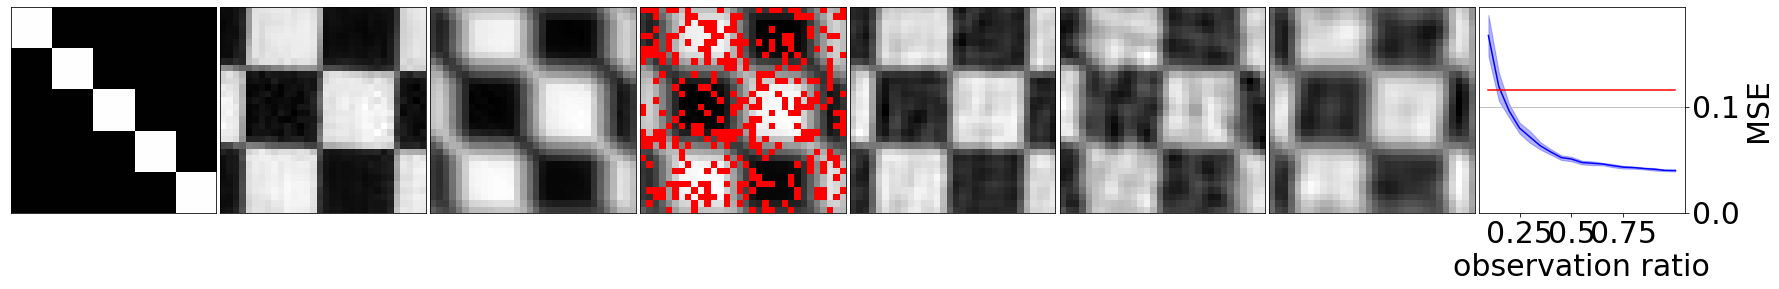

In [12]:
filters = ['flat', 'random', 'centered', 'gauss', 'diag']
image_name = 'chequered'; obs_ratio=7
for i, f in enumerate(filters):
    if i == 0:
        make_plot(image_name, f, obs_ratio, show_titles=True)
    elif i == len(filters)-1:
        make_plot(image_name, f, obs_ratio, hide_x=False)
    else:
        make_plot(image_name, f, obs_ratio)